# LDA for Topic Modeling
Ravindra Bisram

<font color=red>**Topic Modeling**</font> - technique used in NLP to automatically discover latent topics or themes in a collection of documents. 
- The goal of topic modeling is to uncover the underlying semantic structure of a corpus of text by identifying patterns of co-occurring words, and to use these patterns to infer a set of topics that are present in the corpus.

The most popular technique for topic modeling is <font color=green>**Latent Dirichlet Allocation (LDA)**</font>.
- Represents each document as a mixture of topics and each topic as a probability distribution over words. 
- LDA then identifies the most probable topics for each document in the corpus and the most probable words for each topic.

In practice, the LDA algorithm works by iteratively estimating the topic distributions for each document in the corpus and the word distributions for each topic. This is typically done using a technique called <font color=yellow>Gibbs sampling</font>, which involves randomly assigning topic labels to each word in the corpus and then iteratively updating the topic assignments based on the current estimates of the topic and word distributions.

The resulting topic distributions can then be used for a wide range of applications, including text classification, information retrieval, and recommendation systems.

## Imports

In [58]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# import libraries
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns
from nltk.corpus import stopwords
import string
from pprint import pprint as pprint

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#plotting tools
import pyLDAvis
import pyLDAvis.gensim #dont skip this
import matplotlib.pyplot as plt
%matplotlib inline

import topic_modeling as tm
import importlib
importlib.reload(tm)

%reload_ext autoreload
%autoreload 2

# https://www.kaggle.com/datasets/jonathanbesomi/superheroes-nlp-dataset
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels
# https://www.kaggle.com/code/anityagangurde/news-lda-topicmodelling
# https://www.kaggle.com/code/datajameson/topic-modelling-nlp-amazon-reviews-bbc-news/notebook#Hyperparameter-Tuning---Number-of-Topics-and-Alpha



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bisramr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
# Full NLP pipeline for english
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Preprocessing

In [62]:
df = pd.read_csv('BBC-News-Train.csv')
print(df.head())
print()
print(df.info())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


In [10]:
business_df = df[df['Category'] == 'business']
print(business_df.head())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
4        917  enron bosses in $168m payout eighteen former e...  business
8       2034  car giant hit by mercedes slump a slump in pro...  business


## Generate dicitonary and word corpus

In [73]:
# Convert text corpus to list
data = df['Text'].values.tolist()
data_words = list(tm.sent_to_words(data))

# First 10 words of random sample
sample_index = 543
print(data_words[sample_index][0:10])

['profile', 'david', 'miliband', 'david', 'miliband', 'rapid', 'rise', 'through', 'the', 'ranks']


In [64]:
# Create list of stop words
# string.punctuation (from 'string' module) contains a list of punctuations
stop_words = stopwords.words('english') + list(string.punctuation)

In [74]:
# Remove stop words
data_words_npstops= tm.remove_stopwords(data_words, stop_words)

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = tm.lemmatization(data_words_npstops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[sample_index][0:10])

# Compare the nostop, lemmatised version with the original one
print(' '.join(data_words[sample_index][0:20]), '\n')
print(' '.join(data_lemmatized[sample_index][0:20]))


['profile', 'rapid', 'rise', 'rank', 'government', 'continue', 'minister', 'elect', 'safe', 'labour']
profile david miliband david miliband rapid rise through the ranks of government continues with his promotion to cabinet office minister 

profile rapid rise rank government continue minister elect safe labour seat previous job school standard minister role prior last election


In [44]:
# Create dictionary and corpus

# Create dictionary (id for each word)
id2word = corpora.Dictionary(data_lemmatized)
# Create corpus (term-frequency)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

print(corpus[sample_index])

[(4, 3), (39, 2), (41, 1), (43, 1), (63, 1), (78, 1), (81, 11), (91, 1), (99, 1), (108, 1), (122, 5), (124, 8), (132, 1), (135, 1), (136, 1), (137, 1), (152, 1), (156, 1), (169, 1), (175, 2), (198, 1), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 1), (216, 4), (217, 3), (218, 1), (219, 1), (220, 1), (221, 2), (222, 1), (223, 3), (224, 1), (225, 12), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 1), (239, 1), (240, 4), (241, 1), (242, 1), (243, 1), (244, 1), (245, 2), (246, 3), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 3), (253, 1), (254, 2), (255, 2), (256, 1), (257, 1), (258, 3), (259, 1), (260, 1), (261, 1), (262, 1), (263, 2), (264, 2), (265, 7), (266, 1), (267, 1), (268, 1), (269, 1), (270, 3), (271, 1), (272, 1), (273, 2), (274, 1), (275, 1), (276, 1), (277, 1), (278, 4), (279, 1), (280, 1), (281, 1), (282, 1), (283, 1), (284, 1), (285, 2), (286, 1

In [77]:
# human-readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[0:2]])

[[('accounting', 7), ('adjustment', 1), ('agree', 1), ('alert', 2), ('also', 1), ('answer', 1), ('approve', 1), ('argue', 1), ('arguing', 1), ('auditor', 2), ('bankruptcy', 1), ('battery', 1), ('book', 1), ('boss', 1), ('brief', 1), ('business', 1), ('call', 1), ('charge', 3), ('chief', 1), ('collapse', 1), ('committee', 1), ('communication', 1), ('company', 2), ('conspiracy', 1), ('consult', 1), ('convict', 1), ('cooper', 3), ('deal', 1), ('defence', 1), ('defend', 1), ('director', 1), ('discovery', 1), ('early', 1), ('earning', 1), ('ebber', 7), ('emerge', 1), ('employee', 1), ('estimate', 1), ('expense', 1), ('face', 2), ('finance', 1), ('firm', 2), ('first', 1), ('follow', 1), ('former', 2), ('fraud', 4), ('giant', 1), ('give', 1), ('giving', 1), ('green', 1), ('guilty', 1), ('hide', 1), ('hit', 1), ('however', 1), ('inflate', 1), ('internal', 1), ('irregular', 1), ('jail', 1), ('jury', 1), ('know', 1), ('last', 1), ('launch', 1), ('lawyer', 3), ('lead', 1), ('light', 1), ('meet', 

## Building Topic Model

In [46]:
# Build LDA model
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,random_state=100,\
                                          update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [47]:
# print the 10 topics
lda_model.print_topics()

[(0,
  '0.014*"game" + 0.013*"say" + 0.010*"year" + 0.010*"play" + 0.008*"go" + 0.008*"time" + 0.008*"win" + 0.008*"get" + 0.007*"first" + 0.007*"make"'),
 (1,
  '0.018*"say" + 0.014*"use" + 0.014*"people" + 0.008*"mobile" + 0.008*"technology" + 0.008*"phone" + 0.008*"service" + 0.007*"make" + 0.007*"user" + 0.006*"also"'),
 (2,
  '0.024*"film" + 0.014*"good" + 0.013*"year" + 0.011*"say" + 0.009*"show" + 0.008*"award" + 0.008*"also" + 0.008*"star" + 0.008*"include" + 0.007*"top"'),
 (3,
  '0.023*"say" + 0.016*"year" + 0.009*"market" + 0.008*"company" + 0.007*"rise" + 0.006*"firm" + 0.006*"sale" + 0.006*"price" + 0.006*"growth" + 0.006*"business"'),
 (4,
  '0.041*"say" + 0.009*"government" + 0.009*"people" + 0.008*"election" + 0.006*"make" + 0.006*"tell" + 0.006*"labour" + 0.006*"plan" + 0.006*"party" + 0.006*"also"')]

======================================================================================================

<font color=red>**Coherence Score:**</font> a metric used to evaluate the quality of topics generated by a Latent Dirichlet Allocation (LDA) model. 
- It measures the degree of semantic similarity between the top N words in each topic generated by the model.
- The Coherence score is commonly used in the LDA model selection process to identify the optimal number of topics for a given corpus.

======================================================================================================

In [48]:
# coherence score
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)



Coherence Score: 0.46877728727228896


======================================================================================================

In Latent Dirichlet Allocation (LDA), the alpha value, aka the <font color=red>**relevance metric**</font>, is a hyperparameter that controls the sparsity of the per-document topic distributions. 
- Scalar value that determines the prior probability of each topic appearing in a document.

- <font color=purple>**High alpha value:**</font> indicates that documents are likely to contain a mixture of many topics
- <font color=orange>**Low alpha value:**</font> indicates that documents are likely to contain only a few dominant topics. 

The alpha value is a key hyperparameter in LDA that can have a significant impact on the resulting topic model.

A lower alpha value is appropriate when modeling text corpora with fewer topics or when it is expected that documents in the corpus are likely to contain a small number of dominant topics.


======================================================================================================

In [49]:
'''
X-axis: the first principal component, which is a linear combination of the topic-term probabilities that explains the most variance in the data.
Y-axis: the second principal component, which is a linear combination of the topic-term probabilities that explains the second most variance in the data.
Circle size: the overall frequency of the topic in the corpus.
Circle color: the balance between the frequencies of the top words in the topic and the exclusivity of the words to that topic.
'''

# VIsualize the topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.083110  0.133712       1        1  26.904719
3      0.137975 -0.033216       2        1  20.593903
1      0.092588 -0.138414       3        1  19.307987
0     -0.105328  0.137704       4        1  19.281952
2     -0.208344 -0.099785       5        1  13.911440, topic_info=       Term         Freq        Total Category  logprob  loglift
352    film   815.000000   815.000000  Default  30.0000  30.0000
535    game   815.000000   815.000000  Default  29.0000  29.0000
91      use   960.000000   960.000000  Default  28.0000  28.0000
265  people  1310.000000  1310.000000  Default  27.0000  27.0000
358    good   957.000000   957.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
156    make   206.648219  1439.769900   Topic5  -5.1138   0.0312
547    play   156.748620   712.708759   Topic5  -5.3901   0.4580
438    well   157.420016   747.715111   Topic5  -5.3859   0.4144
527     day   138.183494   440.023592   Topic5  -5.5162   0.8142
390     new   134.017599   986.643382   Topic5  -5.5468  -0.0239

[349 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4347      5  0.995473    actor
1359      5  0.996494  actress
3562      2  0.996553  airline
1088      5  0.988986    album
4         1  0.258658     also
...     ...       ...      ...
99        1  0.081116     year
99        2  0.386382     year
99        3  0.092156     year
99        4  0.228469     year
99        5  0.212150     year

[613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [80]:
# Build models accross a range of topic numbers and alpha values
num_topics_range= [2, 5, 7, 10, 20]
alpha_range=[0, 0.01,0.1,1]
model_list, coherence_values = tm.compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)


/Users/bisramr/Documents/Cooper Stuff/Advanced-NLP/LDA-topc-modeling/venv/lib/python3.11/site-packages/gensim/models/ldamodel.py:1127: RuntimeWarning: invalid value encountered in scalar add
  score += gammaln(np.sum(self.alpha)) - gammaln(np.sum(gammad))
/Users/bisramr/Documents/Cooper Stuff/Advanced-NLP/LDA-topc-modeling/venv/lib/python3.11/site-packages/gensim/models/ldamodel.py:1125: RuntimeWarning: invalid value encountered in multiply
  score += np.sum((self.alpha - gammad) * Elogthetad)
/Users/bisramr/Documents/Cooper Stuff/Advanced-NLP/LDA-topc-modeling/venv/lib/python3.11/site-packages/gensim/models/ldamodel.py:1126: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(gammad) - gammaln(self.alpha))


In [98]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df.sort_values("coherence_value", ascending = False)

,alpha,num_topics,coherence_value
12,0.10,7,0.268236
1,0.00,5,0.266370
17,1.00,7,0.266287
3,0.00,10,0.264082
5,0.01,2,0.263768
9,0.01,20,0.261659
15,1.00,2,0.258327
10,0.10,2,0.258092
11,0.10,5,0.256437
6,0.01,5,0.255739


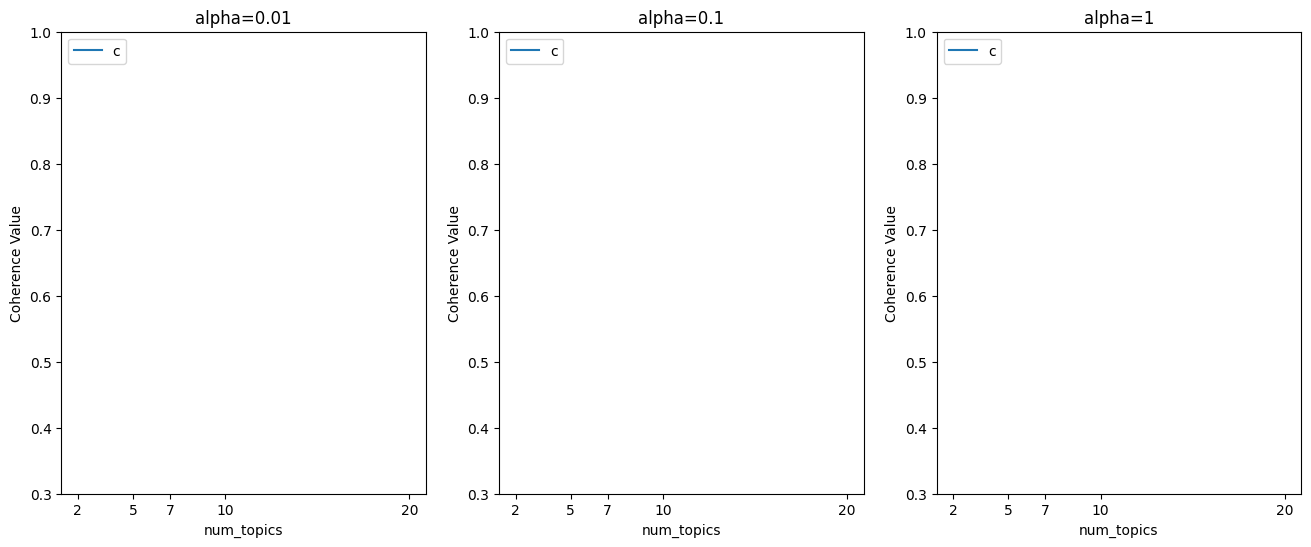

In [79]:
tm.plot_coherence(coherence_df,alpha_range,num_topics_range)

# Summaries

In [93]:
import os
import pandas as pd

# Create an empty list to store the article data
articles = []

# Define the directory path where the articles are stored
dir_path = "BBC News Summary/Summaries"
article_id = 0

# Loop through each subdirectory in the News Articles directory
for subdir in os.listdir(dir_path):
    if os.path.isdir(os.path.join(dir_path, subdir)):
        # Get the category name from the subdirectory name
        category = subdir
        print(category)
        
        # Loop through each text file in the subdirectory
        for filename in os.listdir(os.path.join(dir_path, subdir)):
            # Get the article ID from the filename
            # article_id = os.path.splitext(filename)[0]
            
            # Read in the text from the file
            with open(os.path.join(dir_path, subdir, filename), 'r') as f:
                text = f.read()
            
            # Add the article data to the list
            articles.append([article_id, text, category])

            article_id += 1

# Create a DataFrame from the list of article data
summary_df = pd.DataFrame(articles, columns=['article ID', 'Text', 'Category'])
print(summary_df.info())

entertainment
business
sport
politics
tech
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article ID  2225 non-null   int64 
 1   Text        2225 non-null   object
 2   category    2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB
None


In [95]:
summary_id2word, summary_corpus = tm.gen_dict_and_corpus(summary_df)

['but', 'they', 'still', 'want', 'more', 'they', 'have', 'to', 'want', 'to']
stopwords removed
['still', 'want', 'want', 'big', 'band', 'ever', 'stop', 'want', 'band', 'do']
but they still want more they have to want to be the biggest band ever and not stop wanting it 

still want want big band ever stop want band do considerable power ensure remain big band world accord magazine editor
[(1, 1), (2, 1), (6, 4), (17, 1), (33, 2), (43, 1), (44, 2), (56, 1), (61, 4), (62, 1), (63, 1), (64, 1), (65, 1), (66, 3), (67, 1), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 9), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 1), (110, 2), (111, 1), (112, 3), (113, 1), (114, 1), (115, 1), (116, 1), (117, 1), (118, 1),

In [96]:
# Build LDA model
summary_lda_model= gensim.models.ldamodel.LdaModel(corpus=summary_corpus,id2word=summary_id2word,num_topics=5,random_state=100,\
                                          update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

# print the 10 topics
summary_lda_model.print_topics()

[(0,
  '0.018*"year" + 0.017*"music" + 0.015*"say" + 0.014*"net" + 0.012*"video" + 0.011*"high" + 0.010*"company" + 0.009*"firm" + 0.009*"online" + 0.009*"market"'),
 (1,
  '0.053*"game" + 0.026*"player" + 0.018*"play" + 0.015*"mail" + 0.013*"first" + 0.012*"time" + 0.012*"year" + 0.012*"good" + 0.011*"go" + 0.011*"get"'),
 (2,
  '0.065*"say" + 0.007*"make" + 0.007*"people" + 0.007*"new" + 0.006*"tell" + 0.006*"site" + 0.006*"also" + 0.006*"security" + 0.006*"government" + 0.005*"want"'),
 (3,
  '0.023*"people" + 0.021*"use" + 0.019*"phone" + 0.018*"mobile" + 0.012*"service" + 0.012*"technology" + 0.011*"system" + 0.011*"make" + 0.010*"computer" + 0.009*"user"'),
 (4,
  '0.039*"tv" + 0.026*"virus" + 0.020*"program" + 0.017*"console" + 0.017*"domain" + 0.015*"film" + 0.015*"gaming" + 0.014*"name" + 0.014*"watch" + 0.012*"spam"')]

In [97]:
# VIsualize the topics
pyLDAvis.enable_notebook()
summary_vis=pyLDAvis.gensim.prepare(summary_lda_model,summary_corpus,summary_id2word)
summary_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.133557 -0.006726       1        1  37.309310
0      0.098051 -0.109301       2        1  21.505504
3      0.145681  0.242621       3        1  18.196401
1     -0.032854 -0.216102       4        1  17.025622
4     -0.344436  0.089508       5        1   5.963163, topic_info=         Term         Freq        Total Category  logprob  loglift
765      game  1488.000000  1488.000000  Default  30.0000  30.0000
43        say  4796.000000  4796.000000  Default  29.0000  29.0000
1153   player   749.000000   749.000000  Default  28.0000  28.0000
299        tv   387.000000   387.000000  Default  27.0000  27.0000
1892    phone   589.000000   589.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
72      award    55.018897    66.077615   Topic5  -5.1928   2.6364
266   channel    51.920061    62.582115   Topic5  -5.2507   2.6328
5104  display    44.379118    54.215804   Topic5  -5.4077   2.6194
450      good    66.037139   492.388082   Topic5  -5.0102   0.8105
145      show    62.397784   424.009832   Topic5  -5.0669   0.9033

[282 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2087      1  0.007385  access
2087      3  0.989572  access
62        1  0.032575  accord
62        2  0.724793  accord
62        3  0.240240  accord
...     ...       ...     ...
61        4  0.454484   world
174       1  0.159154    year
174       2  0.552254    year
174       4  0.283519    year
174       5  0.005218    year

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])